In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
sys.path.append("../../src/")
sys.path.append("../../src/model")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import wandb # This is optinal 
wandb.login(host = "https://api.wandb.ai") 


/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ma61sa136 (fderc_diffusion). Use `wandb login --relogin` to force relogin


True

# Load Pre-trained Model 

In [2]:
run = wandb.init(entity ='fderc_diffusion', project="Diffusion-DNA-RNA", name = "test") # Change depending on your proejcts
artifact = run.use_artifact('UTR-Model:v0')
dir = artifact.download()
wandb.finish()


class ModelParameters:
    diffusion_weights_file = 'artifacts/UTR-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    time_schedule = "artifacts/UTR-dataset:v0/time_dependent.npz"
    checkpoint_path = 'artifacts/UTR-Model:v0/diffusion_unconditional_epoch=075.ckpt'
config = ModelParameters() 
DEVICE = "cuda:2" # Any number is fine

wandb: Downloading large artifact UTR-Model:v0, 1499.65MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:2.1


In [3]:
# Introduce Two Models
score_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
score_model = score_model.model
score_model.cuda(device = DEVICE) 


original_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
original_model = original_model.model
original_model.cuda(device = DEVICE) 

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [4]:
# Load Reward model
from grelu.lightning import LightningModel
model = LightningModel.load_from_checkpoint("artifacts/UTR-Model:v0/reward_model.ckpt")
model.eval()
model.to(DEVICE)

def new_reward_model(x):
    x = torch.nn.functional.softmax(x /0.1, -1)
    seq = torch.transpose(x, 1, 2) 
    return model(seq)


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


## Start Fine-Tuning Diffusion Models 

In [5]:
from src.model import ddsm_PPO  as fine_tune

import os
save_name = "./log_finetune_PPO/"
isExist = os.path.exists(save_name)
if not isExist:
   os.makedirs(save_name)


loss_curves, eval_curves = fine_tune.fine_tuning(score_model, new_reward_model, [new_reward_model], original_model,
            learning_rate =3e-3, num_epoch = 400, length = 50, num_steps = 50, accmu = 4,
            batch_size = 128, save_name = save_name, entropy_coff = 0.0,  device= DEVICE)

100%|██████████| 50/50 [00:01<00:00, 48.31it/s]


-0.10610634088516235


100%|██████████| 50/50 [00:01<00:00, 47.07it/s]


-0.1972624659538269


100%|██████████| 50/50 [00:01<00:00, 47.51it/s]


-0.2066236287355423


100%|██████████| 50/50 [00:01<00:00, 48.88it/s]


0.06110208481550217


100%|██████████| 50/50 [00:01<00:00, 47.23it/s]


-0.39747774600982666


100%|██████████| 50/50 [00:01<00:00, 48.53it/s]


-0.41224002838134766


100%|██████████| 50/50 [00:01<00:00, 47.66it/s]


-0.47699296474456787


100%|██████████| 50/50 [00:01<00:00, 46.77it/s]


-0.22207313776016235


100%|██████████| 50/50 [00:00<00:00, 50.41it/s]


-0.00377033744007349


100%|██████████| 50/50 [00:01<00:00, 47.04it/s]


0.28909605741500854


100%|██████████| 50/50 [00:01<00:00, 47.30it/s]


0.49628371000289917


100%|██████████| 50/50 [00:01<00:00, 49.55it/s]


0.5197001695632935


100%|██████████| 50/50 [00:01<00:00, 46.89it/s]


0.6905991435050964


100%|██████████| 50/50 [00:01<00:00, 47.20it/s]


0.9945108890533447


100%|██████████| 50/50 [00:01<00:00, 42.94it/s]


1.0470000505447388


100%|██████████| 50/50 [00:01<00:00, 47.38it/s]


1.0530316829681396


100%|██████████| 50/50 [00:01<00:00, 48.32it/s]


1.0561543703079224


100%|██████████| 50/50 [00:01<00:00, 47.27it/s]


1.0448923110961914


100%|██████████| 50/50 [00:01<00:00, 46.82it/s]


1.0255815982818604


100%|██████████| 50/50 [00:01<00:00, 48.84it/s]


1.033071756362915


100%|██████████| 50/50 [00:01<00:00, 47.07it/s]


1.0488109588623047


100%|██████████| 50/50 [00:01<00:00, 47.05it/s]


1.053943395614624


100%|██████████| 50/50 [00:01<00:00, 49.52it/s]


1.0663459300994873


100%|██████████| 50/50 [00:01<00:00, 46.89it/s]


1.0695576667785645


100%|██████████| 50/50 [00:01<00:00, 49.51it/s]


1.0739703178405762


100%|██████████| 50/50 [00:01<00:00, 47.41it/s]


1.0757365226745605


100%|██████████| 50/50 [00:01<00:00, 47.34it/s]


1.0769016742706299


100%|██████████| 50/50 [00:01<00:00, 49.37it/s]


1.0766522884368896


100%|██████████| 50/50 [00:01<00:00, 47.20it/s]


1.0766422748565674


100%|██████████| 50/50 [00:01<00:00, 47.23it/s]


1.0766253471374512


100%|██████████| 50/50 [00:01<00:00, 49.61it/s]


1.0766481161117554


100%|██████████| 50/50 [00:01<00:00, 47.06it/s]


1.0766503810882568


100%|██████████| 50/50 [00:01<00:00, 47.07it/s]


1.0766395330429077


100%|██████████| 50/50 [00:01<00:00, 49.18it/s]


1.0766652822494507


100%|██████████| 50/50 [00:01<00:00, 47.27it/s]


1.0766634941101074


100%|██████████| 50/50 [00:01<00:00, 47.76it/s]


1.076623797416687


100%|██████████| 50/50 [00:01<00:00, 49.00it/s]


1.0766160488128662


100%|██████████| 50/50 [00:01<00:00, 46.87it/s]


1.0766854286193848


100%|██████████| 50/50 [00:01<00:00, 47.23it/s]


1.0767912864685059


100%|██████████| 50/50 [00:01<00:00, 49.27it/s]


1.076768398284912


100%|██████████| 50/50 [00:01<00:00, 47.46it/s]


1.0767935514450073


100%|██████████| 50/50 [00:01<00:00, 49.35it/s]


1.0767920017242432


100%|██████████| 50/50 [00:01<00:00, 47.03it/s]


1.0767967700958252


100%|██████████| 50/50 [00:01<00:00, 48.86it/s]


1.0767872333526611


100%|██████████| 50/50 [00:01<00:00, 46.68it/s]


1.0767745971679688


100%|██████████| 50/50 [00:01<00:00, 47.25it/s]


1.0767781734466553


100%|██████████| 50/50 [00:01<00:00, 49.34it/s]


1.0767573118209839


100%|██████████| 50/50 [00:01<00:00, 46.68it/s]


1.0767431259155273


100%|██████████| 50/50 [00:01<00:00, 48.38it/s]


1.0767784118652344


100%|██████████| 50/50 [00:01<00:00, 46.76it/s]


1.0767555236816406


100%|██████████| 50/50 [00:01<00:00, 49.26it/s]


1.0767362117767334


100%|██████████| 50/50 [00:01<00:00, 47.23it/s]


1.0767252445220947


100%|██████████| 50/50 [00:01<00:00, 47.13it/s]


1.0766931772232056


100%|██████████| 50/50 [00:01<00:00, 49.52it/s]


1.0766875743865967


100%|██████████| 50/50 [00:01<00:00, 47.14it/s]


1.0766981840133667


100%|██████████| 50/50 [00:01<00:00, 47.47it/s]


1.076699137687683


100%|██████████| 50/50 [00:01<00:00, 49.68it/s]


1.0767239332199097


100%|██████████| 50/50 [00:01<00:00, 49.80it/s]


1.076724886894226


100%|██████████| 50/50 [00:01<00:00, 47.33it/s]


1.0769970417022705


100%|██████████| 50/50 [00:01<00:00, 49.29it/s]


1.077843189239502


100%|██████████| 50/50 [00:01<00:00, 47.17it/s]


1.0712347030639648


100%|██████████| 50/50 [00:01<00:00, 47.17it/s]


1.0657182931900024


100%|██████████| 50/50 [00:01<00:00, 49.24it/s]


1.0597105026245117


100%|██████████| 50/50 [00:01<00:00, 47.13it/s]


1.0422015190124512


100%|██████████| 50/50 [00:01<00:00, 49.67it/s]


1.0356435775756836


100%|██████████| 50/50 [00:01<00:00, 47.26it/s]


1.0043408870697021


100%|██████████| 50/50 [00:01<00:00, 49.50it/s]


0.9971997737884521


100%|██████████| 50/50 [00:01<00:00, 47.13it/s]


0.9791350364685059


100%|██████████| 50/50 [00:01<00:00, 46.95it/s]


0.9817676544189453


100%|██████████| 50/50 [00:01<00:00, 45.26it/s]


0.9727773666381836


100%|██████████| 50/50 [00:01<00:00, 49.48it/s]


0.9676763415336609


100%|██████████| 50/50 [00:01<00:00, 47.15it/s]


0.9623187780380249


100%|██████████| 50/50 [00:01<00:00, 47.35it/s]


0.9548982977867126


100%|██████████| 50/50 [00:00<00:00, 50.36it/s]


0.9539734125137329


100%|██████████| 50/50 [00:01<00:00, 47.13it/s]


0.9421501159667969


100%|██████████| 50/50 [00:01<00:00, 47.38it/s]


0.9378429055213928


100%|██████████| 50/50 [00:01<00:00, 49.45it/s]


0.9206059575080872


100%|██████████| 50/50 [00:01<00:00, 47.18it/s]


0.9199702739715576


100%|██████████| 50/50 [00:01<00:00, 47.12it/s]


0.9097884893417358


100%|██████████| 50/50 [00:01<00:00, 49.01it/s]


0.8981225490570068


100%|██████████| 50/50 [00:01<00:00, 47.17it/s]


0.8942432403564453


100%|██████████| 50/50 [00:01<00:00, 47.89it/s]


0.8976361155509949


100%|██████████| 50/50 [00:01<00:00, 45.77it/s]


0.9524592757225037


100%|██████████| 50/50 [00:01<00:00, 49.43it/s]


0.9914340376853943


100%|██████████| 50/50 [00:01<00:00, 47.21it/s]


1.0134363174438477


100%|██████████| 50/50 [00:01<00:00, 47.57it/s]


1.0317869186401367


100%|██████████| 50/50 [00:01<00:00, 49.89it/s]


1.031568169593811


100%|██████████| 50/50 [00:01<00:00, 43.80it/s]


1.0308209657669067


100%|██████████| 50/50 [00:01<00:00, 47.24it/s]


1.0302594900131226


100%|██████████| 50/50 [00:01<00:00, 46.89it/s]


1.0308643579483032


100%|██████████| 50/50 [00:01<00:00, 49.27it/s]


1.0082879066467285


100%|██████████| 50/50 [00:01<00:00, 47.40it/s]


0.9857046604156494


100%|██████████| 50/50 [00:01<00:00, 48.99it/s]


0.9729475975036621


100%|██████████| 50/50 [00:01<00:00, 47.09it/s]


0.9418954253196716


100%|██████████| 50/50 [00:01<00:00, 47.46it/s]


0.8847570419311523


100%|██████████| 50/50 [00:01<00:00, 49.26it/s]


0.8222912549972534


100%|██████████| 50/50 [00:01<00:00, 43.49it/s]


0.8052923083305359


100%|██████████| 50/50 [00:01<00:00, 47.25it/s]


0.7705284357070923


100%|██████████| 50/50 [00:01<00:00, 48.91it/s]


0.5507653951644897


100%|██████████| 50/50 [00:01<00:00, 47.14it/s]


0.4768414795398712


reward,▂▂▁▂▅▆██████████████████████▇▇▇▇▇████▇▇▅
reward,0.47684


# Evaluation

In [14]:
#### Load Fine-Tuned Model 
time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])
score_finetuned_model = modeld.ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)) 
score_finetuned_model.load_state_dict(torch.load("log_finetune_PPO/_383.pth")) # Change here
score_finetuned_model.cuda(device = DEVICE) 


ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [15]:
### Get Samples after Fine-tune models 

sampler = ddsm.Euler_Maruyama_sampler


allsamples_original = []
for t in range(5):
    samples=[]
    score_finetuned_model.eval()
    samples.append(sampler(score_finetuned_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:00<00:00, 118.13it/s]


In [16]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append(model(batch).detach().cpu() ) 

generated_samples = np.concatenate(generated_samples)

In [17]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(original_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

100%|██████████| 100/100 [00:00<00:00, 114.80it/s]


In [18]:
generated_samples_before = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_before.append( model(batch).detach().cpu() ) 

generated_samples_before = np.concatenate(generated_samples_before)

<Figure size 8000x1000 with 0 Axes>

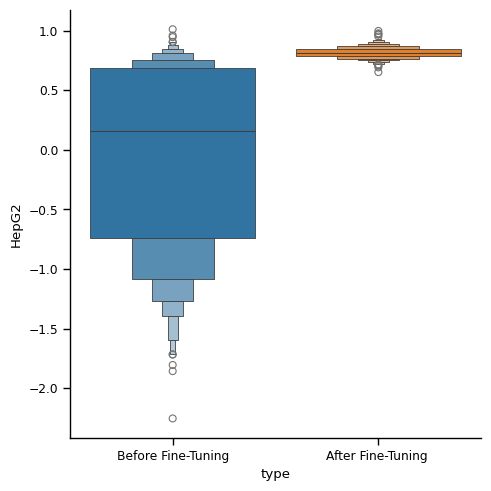

In [19]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate( (generated_samples_before[:,0], generated_samples[:,0]  ), axis= 0)

type1 = ['Before Fine-Tuning' for i in range(len(generated_samples_before[:,0] ))]
type3 = ['After Fine-Tuning ' for i in range(len(generated_samples[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'HepG2': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'HepG2', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/RNA_output_high.png")


